In [73]:

import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import importlib
import crp
importlib.reload(crp)
import warnings
warnings.filterwarnings('ignore')

# SPES Exploration
This is a Single Pulse exploration notebook. The goal here is interact with basic I/O for SPES data and prototype some methods for CRP parameterization 

In [58]:
# # Basic viz
# DATA_FOLDER = '/mnt/ernie_main/000_Data/SPES/data/preprocessed/'
# files = []
# spes_dfs = []
# for pulse in range(1,11):
#     file = f'Epat26/Epat26_CCEP_single_pulses/Epat26_LAC3-LAC4_5mA_pulse_{pulse}.mat'
#     files.append(file)
#     spes_trial = loadmat(os.path.join(DATA_FOLDER, file))
#     fs = spes_trial['fs'][0][0]
#     full_train = spes_trial["pulse"]
#     labels  = [l[0] for l in spes_trial['labels'][0]]
#     df = construct_spes_df(full_train, labels,fs)
#     df['trial'] = pulse
#     spes_dfs.append(df)
# stim_contact = get_stim(files[0])
# spes_dfs = pd.concat(spes_dfs)

In [66]:
sub = 'Epat26'
stim = 'LAC3-LAC4'
ma = '5mA'
spes_dfs = crp.assemble_trial(sub, stim, ma)

In [77]:
plot_channels(spes_dfs, [f'LAH{i}' for i in range(1,11)])

 Miller data is sampled at 2048 Hz


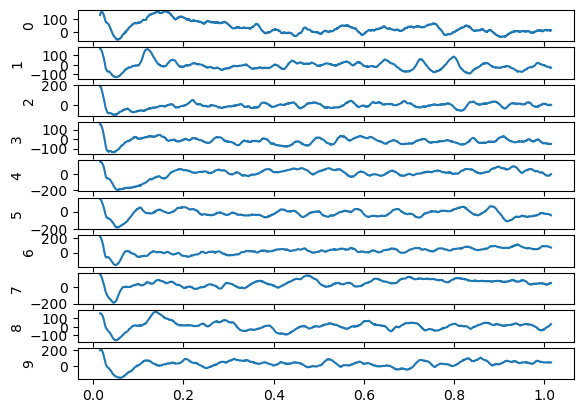

In [5]:
# miller_data = loadmat("../../crp_scripts/sampledata/Fig3_sampledata.mat")
# full_train = miller_data['data']
# t_vec = miller_data['t']
# tpts = np.where(np.abs(t_vec[0,:] -.015 - 0.5) <= 0.5) # equivalent to 0.15 < t_vec < 1
# t_vec = t_vec[0,tpts]
# full_train = full_train[tpts]
# miller_df = pd.DataFrame(data=full_train,index=t_vec[0,:], columns=np.arange(10))
# plot_channels(miller_df,np.arange(10))
# fs = 1/np.mean(np.diff(t_vec))
# print(f" Miller data is sampled at {int(fs)} Hz")


In [6]:
# spes_df = spes_dfs[spes_dfs.trial==5]
# rind10 = np.random.random_integers(0,len(labels)-1,10)
# chs_to_plot = list(spes_df.columns[rind10])
# if stim_contact[0] not in chs_to_plot:
#     chs_to_plot.append(stim_contact[0])
# plot_channels(spes_df, chs_to_plot)


In [7]:
t_ix = lambda t: round(t*fs)

In [8]:
spes_df.columns[0:-1]
region_df = spes_dfs.pivot(columns='trial',values=vals)
set([a for a,_ in region_df.columns])

NameError: name 'spes_df' is not defined

<Axes: >

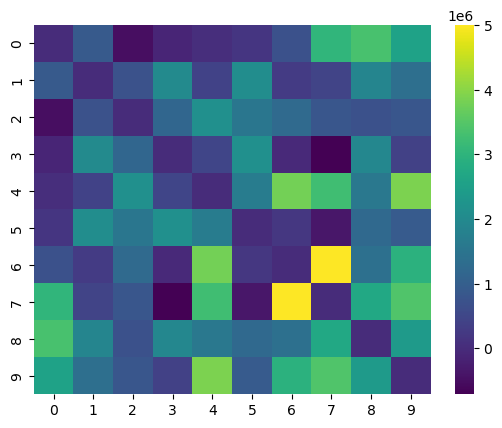

In [9]:
#TODO need to incorporate artifact removal and then work on cross projection. 
#For now, it would be interesting to get global cross projection

k = 10
resp_region = 'LAH3'
resp_areas = miller_df.values #region_df[resp_region].values
#resp_areas = resp_areas[t_ix(.1):t_ix(.15)]
full_crossproj = resp_areas.T@resp_areas
full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(k)
df_full_crossproj = pd.DataFrame(data=full_crossproj)
sns.heatmap(df_full_crossproj, cmap="viridis")


In [10]:
s =0 #paper assumes clean stim t_ix(.025)
cross_dfs = []
import pdb

#TODO consider adding area relationships
for e in np.arange(10,np.max(full_train.shape),5 ):
    #e = t_ix(t)
    win_len = e/fs
    V_raw = resp_areas[s:e,:]
    # norm length of time
    norm = np.linalg.norm(V_raw, axis=0)
    V_norm =V_raw/ norm[None,:]

    full_crossproj = V_norm.T@V_raw
    full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(k)
    full_crossproj /= np.sqrt(fs)
    #pdb.set_trace()
    df = pd.DataFrame(data=full_crossproj.flatten(), columns=['cross_proj'])
    df['win_size'] = win_len
    cross_dfs.append(df)
cross_proj_df = pd.concat(cross_dfs)



In [11]:
m =cross_proj_df.groupby(by='win_size').mean()
max_val = np.max(m['cross_proj'].values)

tr_win = m[m.cross_proj == max_val].index[0] #win_size will be index here
#TODO change back
tr_ind = t_ix(tr_win) #t_ix(tr_win+.15)
print(f"tr_max: {tr_win+.015} at index: {tr_ind}")

tr_max: 0.07603515625 at index: 125


<Axes: xlabel='win_size', ylabel='cross_proj'>

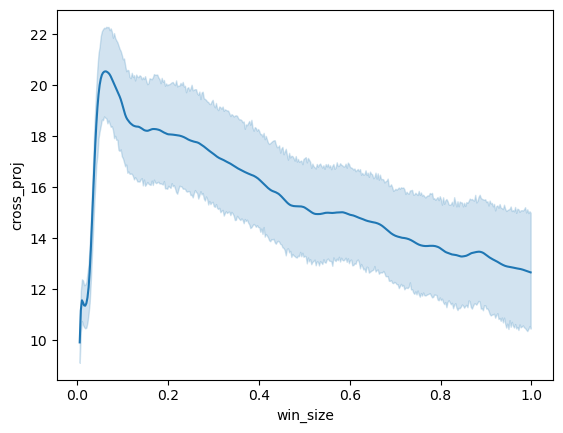

In [12]:
sns.lineplot(data=cross_proj_df, x="win_size", y="cross_proj")

In [13]:
V_tr = resp_areas[s:tr_ind]
eigenV = lin_PCA(V_tr)

In [14]:
n_t, k = eigenV.shape

In [15]:
crp = -1*eigenV[:,0] #get top PC for crp
full_trial = V_tr
#norm = np.linalg.norm(full_trial, axis=1)
#full_norm =full_trial/ norm[:,None]
#alphas = crp.T@V_tr  #full_norm
spes_trial = pd.DataFrame(data=V_tr, columns=[f'raw_{i}'for i in range(k)])
t = np.linspace(0,tr_win ,n_t)
spes_trial['time'] = t


In [16]:
alphas, proj, ep = reparam(V_tr,crp)

df1 = pd.DataFrame(data=proj,columns=[f'proj_{i}'for i in range(k)])
df1['time'] = t

df2 = pd.DataFrame(data=ep, columns=[f'epsilon_{i}' for i in range(k)])
df2['time'] = t


trial_reparam_df = df1.merge(df2,on='time')
trial_reparam_df = trial_reparam_df.merge(spes_trial, on='time')
trial_reparam_df['crp'] = crp

Text(0.5, 0.98, 'CRP Reparamaterization')

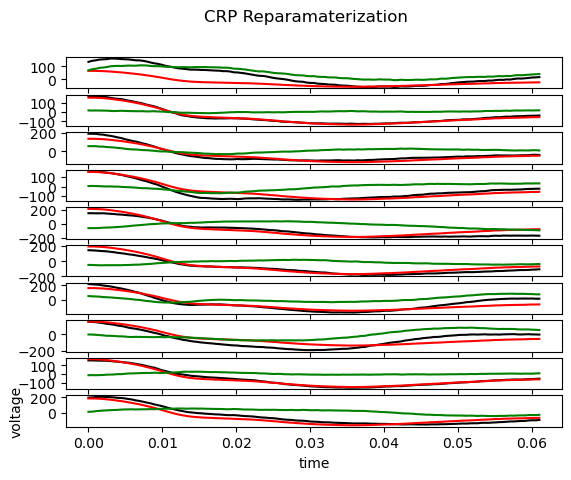

In [17]:
#plot_reparam(trial_reparam_df,10)

my_colors = ['k','r','g']

fig, axes = plt.subplots(nrows=k, ncols=1,sharex=True)
for i in range(k):
    axis=axes[i]
    cols = [f'raw_{i}', f'proj_{i}', f'epsilon_{i}','time']
    ax = trial_reparam_df[cols].plot(kind='line',x='time',color=my_colors, ax=axis,legend=False)
    plt.ylabel('voltage')
    plt.xlabel("time")
    ax.get_legend()
fig.suptitle("CRP Reparamaterization")

Text(0.5, 1.0, 'Reparamaterization on raw voltage')

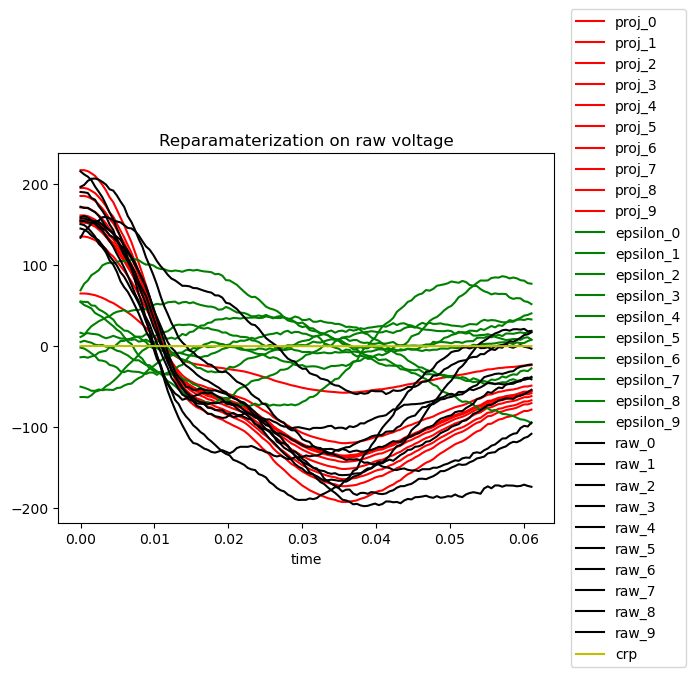

In [18]:
#plot in aggregation
my_colors = ['r']*10+['g']*10+['k']*10 +['y']
trial_reparam_df.plot(kind='line',x='time',  color=my_colors)
plt.legend( bbox_to_anchor=[1.15, 0.5], loc='center')
plt.title("Reparamaterization on raw voltage")

In [22]:
#sns.lineplot(data=total_trial,x="time", y="mV", hue='trial')
#plt.title("CRP vs average normalized response")

## Examining CRP on Normalized Data


Text(0.5, 1.0, 'Reparameterization on Normalized Data')

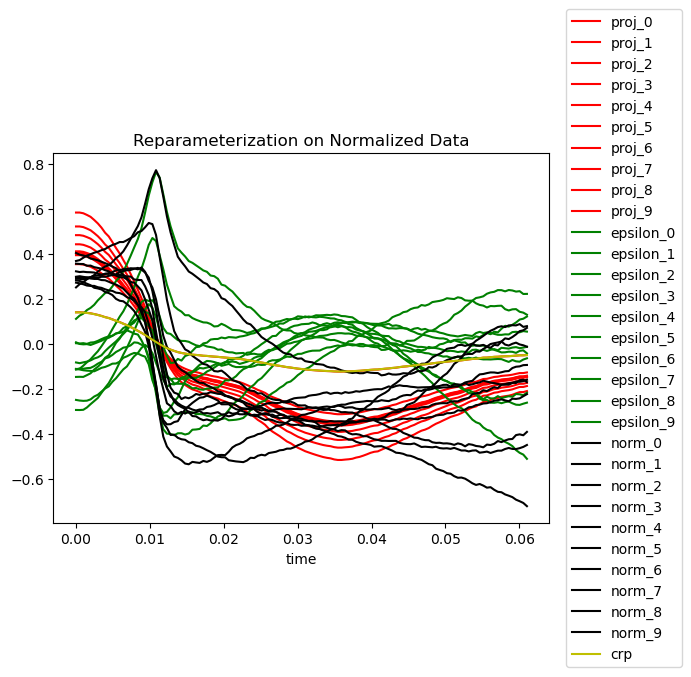

In [20]:
norm = np.linalg.norm(V_tr, axis=1)
V_norm =V_tr/ norm[:,None]
#TODO look at this tomorrow
alphas_norm, proj_norm, ep_norm = reparam(V_norm, crp)

## make trial df 

spes_norm_trial = pd.DataFrame(data=V_norm, columns=[f'norm_{i}'for i in range(k)])
t = np.linspace(0,tr_win ,n_t)
spes_norm_trial['time'] = t


df1 = pd.DataFrame(data=proj_norm,columns=[f'proj_{i}'for i in range(k)])
df1['time'] = t

df2 = pd.DataFrame(data=ep_norm, columns=[f'epsilon_{i}' for i in range(k)])
df2['time'] = t


trial_reparam_df = df1.merge(df2,on='time')
trial_reparam_df = trial_reparam_df.merge(spes_norm_trial, on='time')
trial_reparam_df['crp'] = crp


my_colors = ['r']*10+['g']*10+['k']*10 +['y']

trial_reparam_df.plot(kind='line',x='time',  color=my_colors)
plt.legend( bbox_to_anchor=[1.15, 0.5], loc='center')
plt.title("Reparameterization on Normalized Data")

Text(0.5, 1.0, 'CRP vs avg Normed Data')

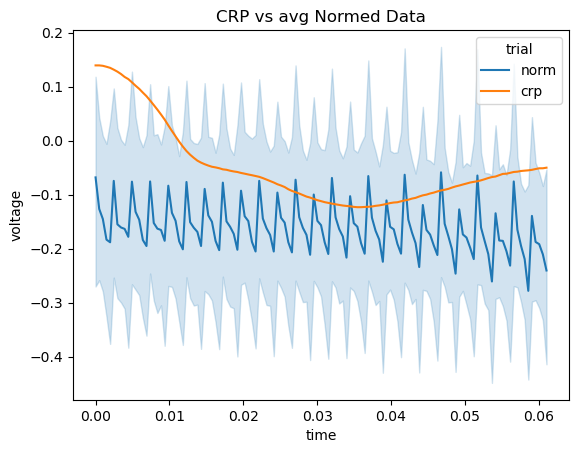

In [21]:
flat_norm = flatten_df(spes_norm_trial,spes_norm_trial.columns[0:-1],'trial', 'time')
flat_norm['trial'] = 'norm'
df = trial_reparam_df[['crp','time']]
df['trial'] = 'crp'
df.columns = ['voltage','time','trial']
flat_norm = pd.concat([flat_norm,df])
sns.lineplot(data=flat_norm,x="time", y="voltage", hue='trial')
plt.title("CRP vs avg Normed Data")

In [ ]:
spes_norm_trial.columns

Index(['norm_0', 'norm_1', 'norm_2', 'norm_3', 'norm_4', 'norm_5', 'norm_6',
       'norm_7', 'norm_8', 'norm_9', 'time'],
      dtype='object')

In [ ]:
def reparam(V_data,crp):
    n = crp.shape[0]
    d = min(V_data.shape)
    alphas = crp.T@V_data
    proj = crp.reshape(n, 1)@alphas.reshape(1,d)
    ep = V_data - proj
    return alphas, proj, ep

def lin_PCA(V):
    """returns the result of lin kernal PCA"""
    [S2,eigen_vectors] = np.linalg.eig(V.T@V,)
    S = np.sqrt(S2)
    sort_inds = np.argsort(S)[::-1]
    S = S[sort_inds]
    eigen_vectors = eigen_vectors[:,sort_inds]
    V_kernel = V@eigen_vectors
    return V_kernel / S[None,:]


def construct_spes_df(spes_trains, contact_labels, fs):
    assert len(contact_labels) == min(spes_trains.shape)
    if np.argmax(spes_trains.shape) != 0:
        spes_trains = spes_trains.T
    nsamps,ch = spes_trains.shape
    t = np.arange(nsamps)/fs
    df = pd.DataFrame(columns=contact_labels, index =t, data=spes_trains)
    return  df

def get_stim(fname):
    fname = os.path.split(fname)[1]
    bipole = fname.split("_")[1] 
    return bipole.split("-")

def plot_reparam(reparam_df,k):
    assert "proj_0" in reparam_df.columns and 'epsilon_0' in reparam_df.columns, "Incorrect columns!"
    fig, axes = plt.subplots(nrows=k, ncols=1, sharex=True)
    for i in range(k):
        cols = [f'proj_{i}', f'epsilon_{i}', 'crp']
        ax = axes[i]
        df = flatten_df(reparam_df,cols,'type','time')
        sns.lineplot(data =df,y='voltage', x='time', hue='type', ax=ax)

def flatten_df(og_df, cols, flat_name, const_col):
    n,_ = og_df.shape
    flat_data = og_df[cols].values.flatten()
    flat_df = pd.DataFrame(data=flat_data,columns=['voltage'])
    flat_cols = []
    for c in cols:
        flat_cols = flat_cols + [c]*n
    flat_df[flat_name] = flat_cols
    #pdb.set_trace()
    flat_df[const_col] = np.tile(og_df[const_col],len(cols))
    return flat_df

def plot_channels(spes_df , channel_list):
    nrows = len(channel_list)
    fig, axes = plt.subplots(nrows=nrows, ncols=1,sharex=True)
    for i,ch in enumerate(channel_list):
        ax = axes[i]
        sns.lineplot(x=spes_df.index, y=spes_df[ch], ax=ax)
    
    